##Manipulation de la Donnée


In [1]:
import os
import numpy as np
import zipfile
from google.colab import drive
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.utils import img_to_array, load_img

####Télécharger les données fournies

In [2]:
# Monter Google Drive
drive.mount('/content/drive')

# Spécifier le chemin vers le fichier zip et le répertoire d'extraction
data_dir = "/content/sample_data/malaria_hematie_dataset.zip"
extracted_dir = "/content/sample_data/malaria_hematie_dataset"

# Vérifier si le fichier zip existe
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Fichier zip introuvable : {data_dir}")

# Extraire les données
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# Définir le répertoire contenant les données extraites
root_folder = os.path.join(extracted_dir, "malaria_hematie_dataset")
data_dir = root_folder if os.path.exists(root_folder) else extracted_dir

# Vérifier la structure du répertoire
for root, dirs, files in os.walk(data_dir):
    print(f"Root: {root}")
    print(f"Subdirectories (Classes): {dirs}")
    print(f"Number of files: {len(files)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Root: /content/sample_data/malaria_hematie_dataset/malaria_hematie_dataset
Subdirectories (Classes): ['parasitized', 'uninfected']
Number of files: 0
Root: /content/sample_data/malaria_hematie_dataset/malaria_hematie_dataset/parasitized
Subdirectories (Classes): []
Number of files: 13779
Root: /content/sample_data/malaria_hematie_dataset/malaria_hematie_dataset/uninfected
Subdirectories (Classes): []
Number of files: 13779


####Charger les données à l'aide de Python

In [3]:
from tensorflow.keras.utils import img_to_array, load_img

# Définir les catégories
categories = ["parasitized", "uninfected"]

# Préparer les chemins d'images et les labels
file_paths = []  # Liste des chemins des images
labels = []      # Liste des labels associés

for category in categories:
    category_path = os.path.join(data_dir, category)
    if not os.path.exists(category_path):
        print(f"Répertoire introuvable : {category_path}")
        continue
    class_label = categories.index(category)  # 0 pour parasitized, 1 pour uninfected
    for img_name in os.listdir(category_path):
        file_paths.append(os.path.join(category_path, img_name))
        labels.append(class_label)

# Vérifier le nombre de données chargées
print(f"Nombre total d'images : {len(file_paths)}")


Nombre total d'images : 27558


####Normaliser les images

In [4]:
# Fonction pour charger, redimensionner et normaliser les images
def load_and_normalize_images(file_paths):
    images = []
    for img_path in file_paths:
        try:
            img = load_img(img_path, target_size=(128, 128))  # Redimensionner à 128x128
            img_array = img_to_array(img) / 255.0  # Normaliser les pixels entre 0 et 1
            images.append(img_array)
        except Exception as e:
            print(f"Erreur lors du chargement de l'image {img_path}: {e}")
    return np.array(images)

# Charger et normaliser les images
images = load_and_normalize_images(file_paths)

# Vérifier les dimensions des images
print(f"Shape des images : {images.shape}")


Shape des images : (27558, 128, 128, 3)


####Encoder les labels

In [5]:
# Encoder les labels en valeurs numériques
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Convertir les labels en one-hot encoding
labels_encoded = to_categorical(labels_encoded, num_classes=len(categories))

# Vérifier les dimensions des labels encodés
print(f"Shape des labels : {labels_encoded.shape}")


Shape des labels : (27558, 2)


####Faire de la data augmentation

In [6]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Définir le dossier où se trouvent les images
base_dir = "/content/sample_data/malaria_hematie_dataset/malaria_hematie_dataset"

# Lister les fichiers avec leurs labels
image_paths = []
labels = []
categories = ["parasitized", "uninfected"]

for label, category in enumerate(categories):
    category_path = os.path.join(base_dir, category)
    for img_name in os.listdir(category_path):
        image_paths.append(os.path.join(category_path, img_name))
        labels.append(label)

#  Séparer en Train (70%) et Test (15%) et Validation (15%)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.30, random_state=42, stratify=labels
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.50, random_state=42, stratify=temp_labels
)

#  Afficher le nombre d'images après séparation
print(f" Répartition des images :")
print(f" Train : {len(train_paths)} images (70%)")
print(f" Validation : {len(val_paths)} images (15%)")
print(f" Test : {len(test_paths)} images (15%)")


 Répartition des images :
 Train : 19290 images (70%)
 Validation : 4134 images (15%)
 Test : 4134 images (15%)


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Création du DataGenerator avec Data Augmentation pour Train et Validation
datagen_train = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,  # Rotation aléatoire
    width_shift_range=0.2,  # Décalage horizontal aléatoire
    height_shift_range=0.2,  # Décalage vertical aléatoire
    zoom_range=0.2,  # Zoom aléatoire
    horizontal_flip=True,  # Flip horizontal aléatoire
    validation_split=0.2  # 20% des images pour la validation
)

corrected_base_dir = "/content/sample_data/malaria_hematie_dataset/malaria_hematie_dataset"

#  Train Generator (80% des images)
train_generator = datagen_train.flow_from_directory(
    corrected_base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    interpolation="nearest"  # Ignore les images corrompues
)

#  Validation Generator (20% des images)
val_generator = datagen_train.flow_from_directory(
    corrected_base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    interpolation="nearest"  # Ignore les images corrompues
)


Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


In [8]:
from tensorflow.keras.utils import Sequence
import cv2

class TestDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size=32, target_size=(128, 128)):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.indexes = np.arange(len(self.image_paths))

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        batch_images = []
        for path in batch_paths:
            img = cv2.imread(path)
            img = cv2.resize(img, self.target_size)
            img = img / 255.0  # Normalisation
            batch_images.append(img)

        return np.array(batch_images), np.array(batch_labels)

# Initialiser le générateur de test
test_generator = TestDataGenerator(test_paths, test_labels)


####Afficher les images augmentées

Found 22048 images belonging to 2 classes.


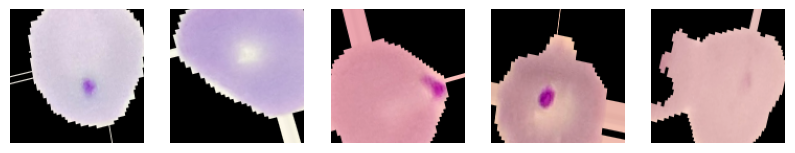

In [9]:
train_generator = datagen_train.flow_from_directory(
    corrected_base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    interpolation="nearest"  # Ignore les images corrompues
)

# Générer un lot d'images augmentées
augmented_images, _ = next(train_generator)

# Afficher 5 images augmentées
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis("off")
plt.show()


##Entraînement de 3 Modèles

###Implémentation de 2 Callbacks

####Early Stopping

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

# Implémenter un callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Surveiller la perte sur l'ensemble de validation
    patience=5,          # Nombre d'époques sans amélioration avant d'arrêter
    restore_best_weights=True  # Restaurer les poids avec la meilleure val_loss
)


####ReduceLROnPlateau

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Implémenter un callback pour réduire le taux d'apprentissage
lr_decay = ReduceLROnPlateau(
    monitor='val_loss',  # Surveiller la perte sur l'ensemble de validation
    factor=0.5,          # Réduire le taux d'apprentissage par ce facteur
    patience=3,          # Nombre d'époques avant de réduire
    min_lr=1e-6          # Limite inférieure pour le taux d'apprentissage
)


###Implémentation de 3 CNN pour la Labellisation

####Modèle from scratch avec Sequential

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Construire un CNN simple avec Sequential
model_scratch = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),  # Applatir les features
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout supplémentaire
    Dense(2, activation='softmax')  # Deux classes (parasitized, uninfected)
])

# Compiler le modèle
model_scratch.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Résumé du modèle
model_scratch.summary()

# Entraîner le modèle
history_scratch = model_scratch.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping, lr_decay]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,578 (28.20 MB)

 Trainable params: 7,392,578 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 149s 209ms/step - accuracy: 0.5041 - loss: 0.8496 - val_accuracy: 0.5564 - val_loss: 0.6874 - learning_rate: 0.0010
Epoch 2/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 163s 237ms/step - accuracy: 0.6200 - loss: 0.6456 - val_accuracy: 0.9011 - val_loss: 0.2917 - learning_rate: 0.0010
Epoch 3/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 136s 197ms/step - accuracy: 0.8944 - loss: 0.3104 - val_accuracy: 0.9113 - val_loss: 0.2608 - learning_rate: 0.0010
Epoch 4/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 139s 202ms/step - accuracy: 0.9018 - loss: 0.2827 - val_accuracy: 0.9073 - val_loss: 0.2758 - learning_rate: 0.0010
Epoch 5/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 137s 199ms/step - accuracy: 0.9014 - loss: 0.2822 - val_accuracy: 0.9152 - val_loss: 0.2535 - learning_rate: 0.0010
Epoch 6/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 151s 218ms/step - accuracy: 0.9120 - loss: 0.2610 - val_accuracy: 0.9200 - val_loss: 0.2341 - learning_rate: 0.0010
Epoch 7/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 139s 202ms/step - accura

In [ ]:
model_scratch.save("scratch.keras")

In [ ]:
from tensorflow.keras.models import load_model
model = keras.load_model()

#### Fine-tuning du VGG16 pré-entraîné sur ImageNet

In [12]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Charger le modèle pré-entraîné VGG16 (sans les couches Dense)

vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Geler les couches du modèle pré-entraîné
vgg16_base.trainable = False

# Ajouter des couches Dense pour l'adaptation finale
x = vgg16_base.output
x = GlobalAveragePooling2D()(x)  # Pooling global
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout pour régularisation
output = Dense(2, activation='softmax')(x)  # Deux classes

# Créer le modèle complet
model_vgg16 = Model(inputs=vgg16_base.input, outputs=output)

# Compiler le modèle
model_vgg16.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Résumé du modèle
model_vgg16.summary()

# Entraîner le modèle
history_vgg16 = model_vgg16.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping, lr_decay]
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,6

 Total params: 14,780,610 (56.38 MB)

 Trainable params: 65,922 (257.51 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 231s 316ms/step - accuracy: 0.7933 - loss: 0.4424 - val_accuracy: 0.8913 - val_loss: 0.2820 - learning_rate: 0.0010
Epoch 2/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 154s 224ms/step - accuracy: 0.8887 - loss: 0.2836 - val_accuracy: 0.8929 - val_loss: 0.2746 - learning_rate: 0.0010
Epoch 3/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 163s 236ms/step - accuracy: 0.8933 - loss: 0.2776 - val_accuracy: 0.9015 - val_loss: 0.2499 - learning_rate: 0.0010
Epoch 4/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 152s 220ms/step - accuracy: 0.9009 - loss: 0.2582 - val_accuracy: 0.9024 - val_loss: 0.2486 - learning_rate: 0.0010
Epoch 5/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 152s 221ms/step - accuracy: 0.8972 - loss: 0.2664 - val_accuracy: 0.9036 - val_loss: 0.2542 - learning_rate: 0.0010
Epoch 6/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 151s 219ms/step - accuracy: 0.9012 - loss: 0.2591 - val_accuracy: 0.9045 - val_loss: 0.2543 - learning_rate: 0.0010
Epoch 7/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 163s 237ms/step - accura

In [13]:
model_vgg16.save("vgg16.keras")

In [ ]:
from tensorflow.keras.models import load_model
model = keras.load_model("/content/drive/MyDrive/Colab Notebooks/vgg16.h5")

####Fine-tuning du ResNet50 pré-entraîné sur ImageNet

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Chargez le modèle de base ResNet50 pré-entraîné.
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Débloquez toutes les couches ou bloquez sélectivement les premières couches.
resnet50_base.trainable = False

# Ajoutez une tête de classification personnalisée.
x = resnet50_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)  # Ajoutez une normalisation par lots (Batch Normalization).
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)  # Deux classes

# Ajoutez une tête de classification personnalisée.
model_resnet50 = Model(inputs=resnet50_base.input, outputs=output)

# Créez le modèle complet.
model_resnet50.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Compilez le modèle avec un taux d’apprentissage réduit.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_decay = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Entraînez le modèle.
history_resnet50 = model_resnet50.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping, lr_decay]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 202s 270ms/step - accuracy: 0.5127 - loss: 0.8639 - val_accuracy: 0.5902 - val_loss: 0.6771 - learning_rate: 1.0000e-05
Epoch 2/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 161s 234ms/step - accuracy: 0.5551 - loss: 0.7751 - val_accuracy: 0.5804 - val_loss: 0.7048 - learning_rate: 1.0000e-05
Epoch 3/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 212s 250ms/step - accuracy: 0.5800 - loss: 0.7368 - val_accuracy: 0.6343 - val_loss: 0.6484 - learning_rate: 1.0000e-05
Epoch 4/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 165s 240ms/step - accuracy: 0.5829 - loss: 0.7376 - val_accuracy: 0.6056 - val_loss: 0.6807 - learning_rate: 1.0000e-05
Epoch 5/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 166s 241ms/step - accuracy: 0.5907 - loss: 0.7308 - val_accuracy: 0.6327 - val_loss: 0.6479 - learning_rate: 1.0000e-05
Epoch 6/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 162s 235ms/step - accuracy: 0.5956 - loss: 0.7218 - val_accuracy: 0.6401 - val_loss: 0.6385 - learning_rate: 1.0000e-05
Epoch 7/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
model_resnet50.save("resnet50.h5")

In [ ]:
from tensorflow.keras.models import load_model
model = keras.load_model("")

In [15]:
def summarize_model_performance(history, model_name):
    """Affiche un résumé des performances du modèle"""
    best_epoch = np.argmin(history.history['val_loss'])  # Trouver l'époque avec la plus basse perte validation

    print(f" Résumé des Performances - {model_name}")
    print(f" Meilleure Epoch : {best_epoch + 1}")
    print(f" Train Accuracy : {max(history.history['accuracy']):.4f}")
    print(f" Validation Accuracy : {max(history.history['val_accuracy']):.4f}")
    print(f" Train Loss : {min(history.history['loss']):.4f}")
    print(f" Validation Loss : {min(history.history['val_loss']):.4f}")
    print("-" * 50)

#  Affichage des performances des trois modèles
# summarize_model_performance(history_resnet50, "ResNet50")
summarize_model_performance(history_vgg16, "VGG16")
# summarize_model_performance(history_scratch, "From Scratch")


 Résumé des Performances - VGG16
 Meilleure Epoch : 13
 Train Accuracy : 0.9136
 Validation Accuracy : 0.9151
 Train Loss : 0.2329
 Validation Loss : 0.2320
--------------------------------------------------


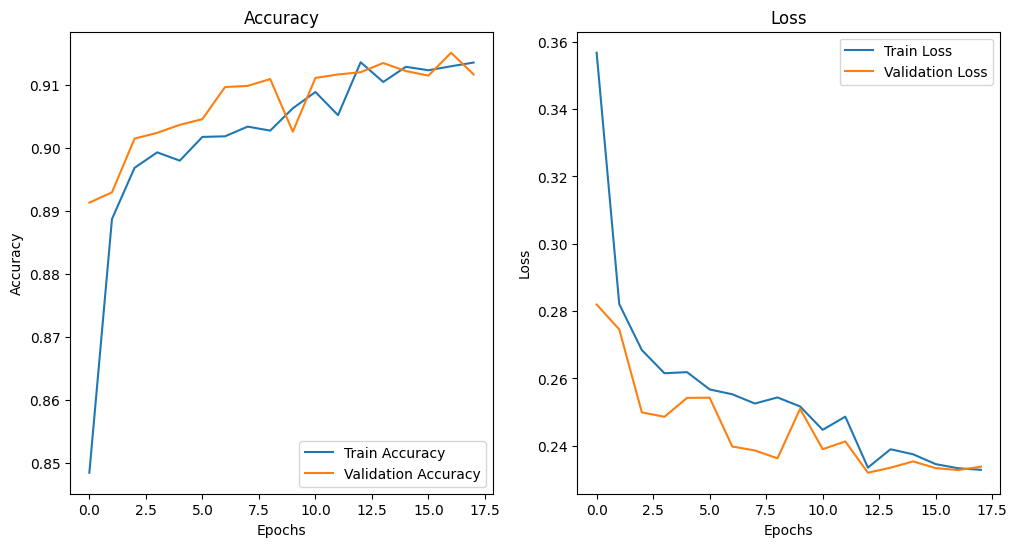

In [16]:
# Tracez l’historique d’entraînement pour la précision et la perte.
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Graphique de précision.
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    #  Graphique de perte.
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Appelez la fonction.
plot_training_history(history_vgg16)


###Entraînement des 3 modèles à l'aide des Callbacks

###Test des Modèles

####Afficher la Courbe ROC et Calculer l'AUC

130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step


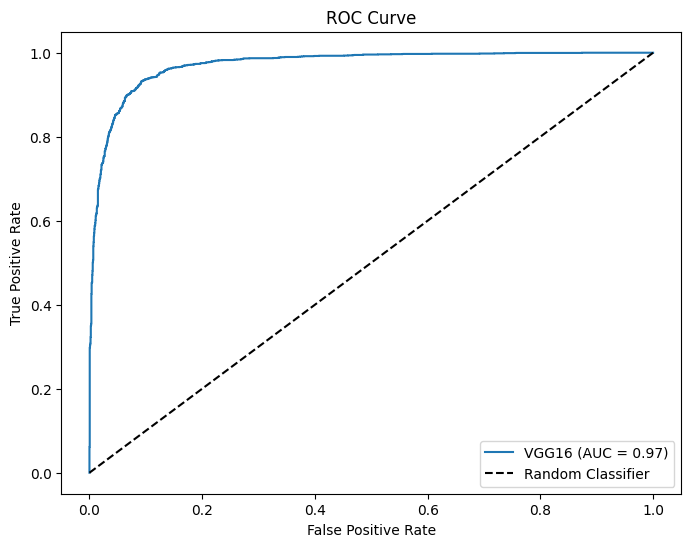

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

#  Obtenir les probabilités prédites par le modèle
# y_proba_resnet50 = model_resnet50.predict(test_generator)
y_proba_vgg16 = model_vgg16.predict(test_generator)
# y_proba_scratch = model_scratch.predict(test_generator)

#  Prendre uniquement la probabilité de la classe positive (1)
y_true = test_generator.labels
# y_proba_resnet50 = y_proba_resnet50[:, 1]
y_proba_vgg16 = y_proba_vgg16[:, 1]
# y_proba_scratch = y_proba_scratch[:, 1]

#  Calculer les courbes ROC
# fpr_resnet50, tpr_resnet50, _ = roc_curve(y_true, y_proba_resnet50)
# auc_resnet50 = auc(fpr_resnet50, tpr_resnet50)

fpr_vgg16, tpr_vgg16, _ = roc_curve(y_true, y_proba_vgg16)
auc_vgg16 = auc(fpr_vgg16, tpr_vgg16)

# fpr_scratch, tpr_scratch, _ = roc_curve(y_true, y_proba_scratch)
# auc_scratch = auc(fpr_scratch, tpr_scratch)

#  Afficher les courbes ROC
plt.figure(figsize=(8, 6))
# plt.plot(fpr_resnet50, tpr_resnet50, label=f"ResNet50 (AUC = {auc_resnet50:.2f})")
plt.plot(fpr_vgg16, tpr_vgg16, label=f"VGG16 (AUC = {auc_vgg16:.2f})")
# plt.plot(fpr_scratch, tpr_scratch, label=f"From Scratch (AUC = {auc_scratch:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


####Calculer la Matrice de Confusion

130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step


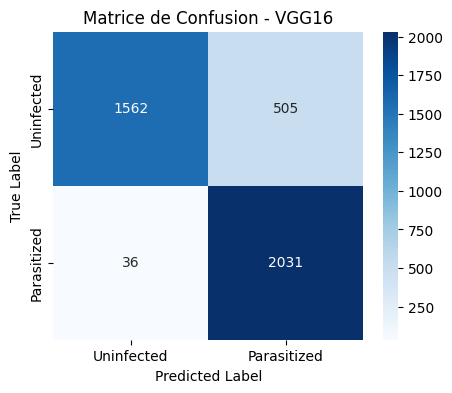

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#  Obtenir les classes prédites (0 ou 1)
# y_pred_resnet50 = np.argmax(model_resnet50.predict(test_generator), axis=1)
y_pred_vgg16 = np.argmax(model_vgg16.predict(test_generator), axis=1)
# y_pred_scratch = np.argmax(model_scratch.predict(test_generator), axis=1)

#  Matrices de confusion
# cm_resnet50 = confusion_matrix(y_true, y_pred_resnet50)
cm_vgg16 = confusion_matrix(y_true, y_pred_vgg16)
# cm_scratch = confusion_matrix(y_true, y_pred_scratch)

#  Fonction pour afficher la matrice de confusion
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Uninfected", "Parasitized"], yticklabels=["Uninfected", "Parasitized"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Matrice de Confusion - {model_name}")
    plt.show()

#  Affichage des matrices
# plot_confusion_matrix(cm_resnet50, "ResNet50")
plot_confusion_matrix(cm_vgg16, "VGG16")
# plot_confusion_matrix(cm_scratch, "From Scratch")


####Calculer les Métriques de Performance

In [23]:
from sklearn.metrics import classification_report

#  Calcul des métriques
# report_resnet50 = classification_report(y_true, y_pred_resnet50, target_names=["Uninfected", "Parasitized"])
report_vgg16 = classification_report(y_true, y_pred_vgg16, target_names=["Uninfected", "Parasitized"])
# report_scratch = classification_report(y_true, y_pred_scratch, target_names=["Uninfected", "Parasitized"])

#  Affichage des résultats
# print(" Classification Report - ResNet50")
# print(report_resnet50)

print("\n Classification Report - VGG16")
print(report_vgg16)

# print("\n Classification Report - From Scratch")
# print(report_scratch)



 Classification Report - VGG16
              precision    recall  f1-score   support

  Uninfected       0.98      0.76      0.85      2067
 Parasitized       0.80      0.98      0.88      2067

    accuracy                           0.87      4134
   macro avg       0.89      0.87      0.87      4134
weighted avg       0.89      0.87      0.87      4134

